# Spatial Tranformer plus small ConvNet
Download the VGG16 weights to the folder "checkpoints" from this source:

https://github.com/tensorflow/models/tree/master/research/slim

The data should be stored as follows

.../train<pre>
/pso
/ecz
</pre>
.../validation <pre>
/pso  
/ecz 
</pre>
.../test<pre>
/pso  
/ecz  
</pre>

In [108]:
# for specifying which GPU to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf

In [109]:
import glob
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.slim.nets import vgg
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from random import shuffle
import pickle
import datetime
import os
import sys
sys.path.append(os.path.join('.', '..')) 
from spatial_transformer import transformer
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d, dropout
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib import slim
from tensorflow.contrib.slim.nets import vgg
slim = tf.contrib.slim

## Set up data paths

In [110]:
DIM = 224
nchannels = 3
img_height, img_width = DIM, DIM
NUM_CLASSES = 2
NUM_EPOCHS = 50
BATCH_SIZE = 100

In [111]:
checkpoints_dir =          # path to the VGG16 weights
train_data_dir =           # path to the train data directory
validation_data_dir =      # path to the validation data directory
test_data_dir =            # path to the test data directory
tensorboard_dir =          # path to the tensorboard directory

train_pso = glob.glob(train_data_dir + "/pso/*.png")
train_ecz = glob.glob(train_data_dir + "/ecz/*.png")
val_pso = glob.glob(validation_data_dir + "/pso/*.png")
val_ecz = glob.glob(validation_data_dir + "/ecz/*.png")

In [112]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    preprocessing_function = preprocess_input
)

train_generator = datagen.flow_from_directory(
        train_data_dir,  
        target_size=(img_height, img_width),  
        batch_size=BATCH_SIZE,
        class_mode='categorical')  

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 40000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


## Visualize the input

In [ ]:
n = 4
dummy_batch_size = n*n

x_batch, y_batch = train_generator.next()

idx = 0
canvas = np.zeros((DIM*n, n*DIM, nchannels))
for i in range(n):
    for j in range(n):
        img = x_batch[idx]
        mi = np.min(img)
        img = img - mi
        ma = np.max(img)
        img = img / ma
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = img
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('canvas of {0}x{0} images'.format(DIM))
plt.axis('off')

plt.show()


## Build the Spatial Transformer

In [120]:

def build_STN_model(x_pl, input_width, input_height, output_dim):
           
    with tf.variable_scope("localization"):
        
        # convert from RGB to HSV
        hsv_image = tf.image.rgb_to_hsv(x_pl)
        #hsv_image = tf.slice(hsv_image, [0,0,0,1], [-1,-1,-1,1])
        print("HSV shape,",hsv_image.get_shape())
        
        with slim.arg_scope([slim.conv2d], padding='SAME',
                  weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                  weights_regularizer=slim.l2_regularizer(0.5)):
            net = slim.max_pool2d(hsv_image, [2, 2], scope='localization1')
            net = slim.conv2d(net, 8, [5, 5], scope='localozation2')
            net = slim.max_pool2d(net, [2, 2], scope='localization3')
            net = slim.conv2d(net, 8, [3, 3], scope='localization4')
            net = slim.flatten(net)
            loc_l5 = slim.fully_connected(net, 50,
                weights_initializer=tf.contrib.layers.xavier_initializer(),
                weights_regularizer=slim.l2_regularizer(1.0),
                scope='localization5')



        W_loc_out = tf.get_variable("localization_loc-out", [50, 6], initializer=tf.constant_initializer(0.0))
        initial = np.array([[1, 0, 0], [0, 1, 0]])
        initial = initial.astype('float32')
        initial = initial.flatten()
        b_loc_out = tf.Variable(initial_value=initial, name='b-loc-out')
        loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out
        
        # If you wush to clip the output parameters
        # loc_out = tf.clip_by_value(loc_out, -1, 1)

    # spatial transformer
    l_trans1 = transformer(x_pl, loc_out, out_size=(DIM, DIM))
    l_trans1.set_shape([None, DIM, DIM, nchannels])

    print( "Transformer network output shape: ", l_trans1.get_shape())

    return l_trans1, loc_out, hsv_image

## Build the ConvNet

In [123]:
def build_ConvNet(inputs):
    inputs = tf.cast(inputs, tf.float32)
    with tf.variable_scope("ConvNet"):
        
        with slim.arg_scope([slim.conv2d], padding='SAME',
                  weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                  weights_regularizer=slim.l2_regularizer(0.5)):
            net = slim.conv2d(inputs, 16, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.conv2d(net, 16, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.conv2d(net, 32, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.conv2d(net, 32, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
    fc = slim.flatten(net)
    fc = slim.fully_connected(fc, 256,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer=slim.l2_regularizer(0.0005),
        scope='finetune/fc1')
    fc_out= slim.fully_connected(fc, 2,
        activation_fn=tf.nn.softmax,
        weights_initializer=tf.contrib.layers.xavier_initializer(),
        weights_regularizer=slim.l2_regularizer(0.0005),
        scope='finetune/fc2')
    
    print( "ConvNet output shape: ", net.get_shape())
    return net, fc_out

In [124]:
def loss_and_acc(logits, labels):
    with tf.name_scope("loss"):
        # computing cross entropy per sample
        cross_entropy = -tf.reduce_sum(labels * tf.log(logits+1e-8), reduction_indices=[1])

        # averaging over samples
        cross_entropy = tf.reduce_mean(cross_entropy)
        
        # accuracy
        argmax_logits = tf.to_int32(tf.argmax(logits, axis=1))
        argmax_labels = tf.to_int32(tf.argmax(labels, axis=1))
        correct = tf.to_float(tf.equal(argmax_logits, argmax_labels))
        accuracy = tf.reduce_mean(correct)
        
        # AUC of the ROC
        auc, update_op_auc = tf.metrics.auc(labels, logits)

    return cross_entropy, accuracy, argmax_logits, update_op_auc
        
def optimize(losses, lr_pl, trainable_vars, g_step):
    
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

    # applying the gradients
    train_op = optimizer.minimize(losses, var_list=trainable_vars, global_step=g_step)
    
    return train_op

## Stitch it together

In [125]:
tf.reset_default_graph()

# input images
x_pl = tf.placeholder(tf.float32, [None, DIM, DIM, nchannels], name="input")
# corresponding labels as onehot encoding
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="output")
# learning rate placeholder
lr_pl = tf.placeholder(tf.float32, shape=[], name="learning-rate")
# keep track of training steps. Incremements by 1 each time tf.optimizer.minimize is called
global_step = tf.Variable(initial_value=0, trainable=False)  

# the result of the transform, the weights used for the transform and the HSV image
l_transform, w_transform, hsv = build_STN_model(x_pl, DIM, DIM, NUM_CLASSES)
# the final convnet layer output and the logits from the fully connected layer on top
net_out, logits = build_ConvNet(l_transform)

# define losses and training operation
loss, accuracy, prediction, auc_op = loss_and_acc(logits, y_pl)

# training the convnet
trainable_vars1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"ConvNet")
train_op1 = optimize(loss, lr_pl, trainable_vars1, global_step)

# training the spatial transformer 
trainable_vars3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,"localization")
train_op3 = optimize(loss, lr_pl, trainable_vars3, global_step)

# training everything
trainable_vars4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
train_op4 = optimize(loss, lr_pl, trainable_vars4, global_step)

# add TensorBoard summaries for all variables
tf.summary.merge_all()
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)

HSV shape, (?, 224, 224, 3)
Transformer network output shape:  (?, 224, 224, 3)
ConvNet output shape:  (?, 14, 14, 32)


<tf.Tensor 'Evaluation/accuracy:0' shape=() dtype=string>

In [127]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=1)

# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())  # this is needed for auc for some reason

file_writer = tf.summary.FileWriter(tensorboard_dir, sess.graph)
# Make run-options
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE,
                            output_partition_graphs=True)
run_metadata = tf.RunMetadata()

## Test the forward pass

In [128]:
res = sess.run(fetches=logits, feed_dict={x_pl: x_batch})
assert res.shape == (len(x_batch), 2), "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y_pl.shape) + ' but was ' + str(res.shape)

print('Forward pass successful!')

Forward pass successful!


## Do the training

In [132]:
# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()

summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)

def train_epoch(learning_rate, training_op):
    num_samples = train_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    aucs = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_tr, y_batch_tr = train_generator.next()
        fetches_tr = [training_op, loss, accuracy, prediction, summaries, global_step, l_transform, w_transform, auc_op]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: y_batch_tr, lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        costs += [res[1]]
        accs += [res[2]]
        aucs += [res[8]]
        summarywriter_train.add_summary(res[4], res[5])
    print("")    
    auc = res[8] # the auc_op is calculated a running estimate of the auc, therefore we do not have to keep track of this for each batch
    sess.run(tf.local_variables_initializer())  # since the auc is a running estimate we need to reset it after each epoch
    return np.mean(costs), np.mean(accs), summaries, auc


def eval_epoch():
    num_samples = validation_generator.n
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    accs = []
    aucs = []
    preds = []
    
    pred_list = []
    y_list = []
    transform_list = []
    weight_list = []
    for i in range(num_batches):
        if i % 10 == 0:
            print(i, end=', ')
        X_batch_val, y_batch_val = validation_generator.next()
        fetches_val = [loss, accuracy, prediction, summaries, global_step, l_transform, w_transform, auc_op]
        feed_dict_val = {x_pl: X_batch_val, y_pl: y_batch_val}
        res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
        costs += [res[0]]
        accs += [res[1]]
        aucs += [res[7]]
        preds += [res[2]]
        summarywriter_valid.add_summary(res[3], res[4])
    preds_ = np.concatenate(preds, axis=0)
    auc = res[7] # the auc_op calculated a running estimate of the auc, therefore we do not have to keep track of this for each batch
    sess.run(tf.local_variables_initializer())  # since the auc is a running estimate we need to reset it after each epoch
    print('')
    return np.mean(costs), np.mean(accs), preds_, summaries, auc

In [133]:
NUM_EPOCHS = 100

valid_accs, train_accs, test_accs = [], [], []
valid_precs, train_precs, valid_recs, train_recs = [], [], [], []
train_costs, valid_costs = [], []
train_aucs, valid_aucs = [], []

learning_rate=0.00001
# define which variables are included in the training
tr_op = train_op4
print('Number of epochs: %s' % NUM_EPOCHS)

try:
    for n in range(NUM_EPOCHS):
        print("Epoch %d:" % n, end=', ')
        print('\ntrain:', end=', ')
        train_cost, train_acc, train_summary, train_auc = train_epoch(learning_rate, tr_op)
        train_costs += [train_cost]
        train_accs += [train_acc]
        train_aucs += [train_auc]

        print('valid:', end=', ')
        valid_cost, valid_acc, preds, valid_summary, valid_auc = eval_epoch()
        valid_costs += [valid_cost]
        valid_accs += [valid_acc]
        valid_aucs += [valid_auc]


        print("train cost {0:.2}, train acc {1:.2}, val cost {2:.2}, val acc {3:.2}".format(
                train_cost, train_acc, valid_cost, valid_acc))
        print("train auc {0:.2}, val auc {1:.2}".format(train_auc, valid_auc))
        
        # learning rate annealing
        if (n+1) % 20 == 0:
            learning_rate = learning_rate * 0.7
            print("New LR:", learning_rate)
        
except KeyboardInterrupt:
    pass

Number of epochs: 100
Epoch 0:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.69, train acc 0.51, val cost 0.69, val acc 0.56
train auc 0.51, val auc 0.55
Epoch 1:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.69, train acc 0.55, val cost 0.69, val acc 0.56
train auc 0.56, val auc 0.55
Epoch 2:, 
train:, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 
valid:, 0, 10, 20, 30, 
train cost 0.69, train acc 0.56, val cost 0.69, val acc 0.54
train auc 0.57, val auc 0.56
Epoch 3:,

In [31]:
# save session?
saver = tf.train.Saver()
save_path = saver.save(sess, "output/02ST.ckpt")
    

## Plot errors and zoom

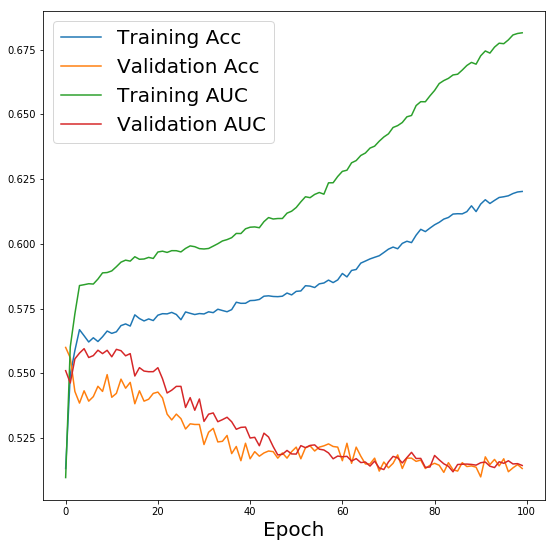

In [134]:
plt.figure(figsize=(9,9))
plt.plot(np.array(train_accs), label='Training Acc')
plt.plot(np.array(valid_accs), label='Validation Acc')
plt.plot(np.array(train_aucs), label='Training AUC')
plt.plot(np.array(valid_aucs), label='Validation AUC')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
# plt.savefig('output/STN_ACC_AUC')
plt.show()

## Show original image, transformed image and the weights used for transformation

In [ ]:
X_batch_val, y_batch_val = validation_generator.next()
fetches_val = [prediction, l_transform, w_transform, hsv, net_out]
feed_dict_val = {x_pl: X_batch_val}
res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
output_eval, transform_eval, weight_eval, hsv_im, convnet = tuple(res)

print(X_batch_val.shape)

plt.figure(figsize=(10,8))

offset = 0

for i in range(3):
    img = X_batch_val[i+offset]
    mi = np.min(img)
    img = img - mi
    ma = np.max(img)
    img = img / ma
    trans = transform_eval[i+offset]
    mi = np.min(trans)
    trans = trans - mi
    ma = np.max(trans)
    trans = trans / ma

    plt.subplot(331+i*3)
    plt.imshow(img, interpolation='none')
    if i == 0:
        plt.title('Original {0}x{0}'.format(X_batch_val.shape[1]), fontsize=10)
    plt.axis('off')
    plt.subplot(332+i*3)
    plt.imshow(trans, interpolation='none')
    if i == 0:
        plt.title('Transformed {0}x{0}'.format(l_transform.shape[1]), fontsize=10)
    plt.axis('off')
    plt.subplot(333+i*3)
    plt.imshow(weight_eval[i+offset].reshape(2,3), interpolation='nearest', cmap='jet')
    plt.colorbar()
    if i == 0:
        plt.title('Transformation weights', fontsize=10)
    plt.axis('off')
    
plt.tight_layout()
# plt.savefig('output/STN_weights')
plt.show()

## Test data

In [40]:
test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

num_samples = test_generator.n
num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))

test_logits = np.zeros((num_samples, 2))
y = np.zeros((num_samples, 2))

for i in range(num_batches):

    x_batch_test, y_batch_test = test_generator.next()
    n_batch = x_batch_test.shape[0]
    print("batch no {}, number of samples: {}".format(i+1, n_batch))
    fetches_test = [logits, prediction, accuracy, auc_op]
    feed_dict_test= {x_pl: x_batch_test, y_pl: y_batch_test}
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    
    test_logits[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = res[0]
    y[i*BATCH_SIZE: i*BATCH_SIZE + n_batch, :] = y_batch_test

Found 617 images belonging to 2 classes.
batch no 1, number of samples: 100
batch no 2, number of samples: 100
batch no 3, number of samples: 100
batch no 4, number of samples: 100
batch no 5, number of samples: 100
batch no 6, number of samples: 100
batch no 7, number of samples: 17


In [54]:
# For the ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y[:, 0], test_logits[:, 0])
auc = metrics.auc(fpr, tpr)
print("Sklearn auc: {}".format(auc))

Sklearn auc: 0.5838687150837989


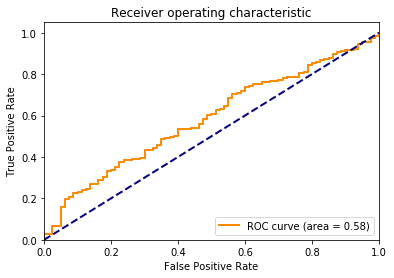

In [55]:
plt.plot(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = {0:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('output/STN_ROC')
plt.show()

In [44]:
acc = np.sum(np.equal(np.argmax(y, axis=1), np.argmax(test_logits, axis=1)))/num_samples

print("acc: {0:0.2f}, auc: {1:0.2f}".format(acc, auc))

acc: 0.50, auc: 0.58


In [45]:
# indices for positive and negative examples
idxp = np.argmax(y, axis=1) == 0
idxn = np.argmax(y, axis=1) == 1

tp = np.sum(np.equal(np.argmax(y[idxp, :], axis=1), np.argmax(test_logits[idxp, :], axis=1)))
tn = np.sum(np.equal(np.argmax(y[idxn, :], axis=1), np.argmax(test_logits[idxn, :], axis=1)))
fp = np.sum(np.argmax(y[idxn, :], axis=1) != np.argmax(test_logits[idxn, :], axis=1))
fn = np.sum(np.argmax(y[idxp, :], axis=1) != np.argmax(test_logits[idxp, :], axis=1))

print(tp, tn, fp, fn)

prec = tp / (tp + fp)
rec = tp / (tp + fn)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print("Precision, Recall, TPR, FPR")
print(prec, rec, tpr, fpr)

258 52 28 279
Precision, Recall, TPR, FPR
0.902097902098 0.480446927374 0.480446927374 0.35


## Inspect classifications on the test set

In [ ]:
n = 17
offset = 0
plt.figure(figsize=(100,100))
for i in range(n):
    plt.subplot(n,1,i+1)
    img = x_batch_test[i + offset]
    mi = np.min(img)
    img = img - mi
    ma = np.max(img)
    img = img / ma
    plt.imshow(img)
    plt.title('logits: {0:3.2}  {1:3.2}, truth: {2}'.format(res[0][i][0],res[0][i][1], y_batch_test[i+offset]))